# Image Classifier

CIFAR-10 image classifier with PyTorch

<img alt="A photo of a man on an elephant with an ML-generated overlay showing objects in the frame" src="https://upload.wikimedia.org/wikipedia/commons/a/ae/DenseCap_%28Johnson_et_al.%2C_2016%29_%28cropped%29.png" width=450px>

An image classifier is an ML model that recognizes objects in images. We can build image classifiers by feeding tens of thousands of labelled images to a neural network. Tools like PyTorch train these networks by evaluating their performance against the dataset.

Let's build an image classifier that detects planes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. We'll download a dataset, configure a neural network, train a model, and evaluate its performance.

Files already downloaded and verified
Files already downloaded and verified


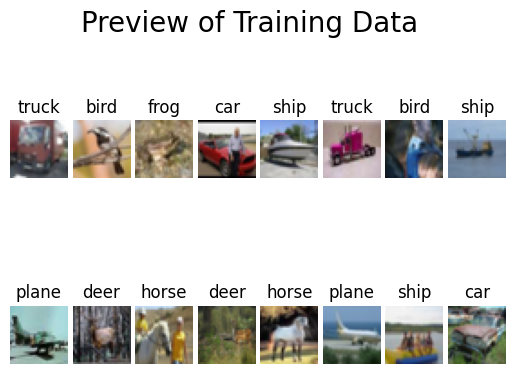

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
batch_size=16
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print("Downloading data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5 # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.subplots_adjust(hspace=0.01, wspace=0.08)  # Adjust the value as needed
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

# Define a convolutional neural network
class Net(nn.Module):
    SLOPE = 0.01
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        #init Conv2d
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')

        # Initialize linear weights
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('leaky_relu', Net.SLOPE))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('leaky_relu', Net.SLOPE))
        nn.init.xavier_uniform_(self.fc3.weight, gain=1.0)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.leaky_relu(self.fc1(x), negative_slope=Net.SLOPE)
        x = F.leaky_relu(self.fc2(x), negative_slope=Net.SLOPE)
        # x = F.softmax(self.fc3(x), dim=1)
        x = self.fc3(x)
        return x
net = Net()

# Load previously trained model
PATH = './cifar_net3.pth'
try:
   # optimizer probably loaded from file as well
   net.load_state_dict(torch.load(PATH), strict=True, assign=True)
except FileNotFoundError:
    pass

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-7)
# Define the learning rate scheduler
## scheduler = ExponentialLR(optimizer, gamma=0.8)  # gamma controls the decay rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, threshold=1e-4, threshold_mode="abs", min_lr=1e-8)

print("Your network is ready for training!")

Your network is ready for training!


# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [7]:
from tqdm import tqdm

EPOCHS = 5
net.train()
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 
                                  desc=f"Epoch {epoch + 1} of {EPOCHS} / lr={scheduler.get_last_lr()[0]:.1e}",
                                  leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")
    scheduler.step(running_loss / len(trainloader))

# Save our trained model
torch.save(net.state_dict(), PATH)
print(" ... finished")

Training...


Epoch 1 of 5 / lr=1.0e-05: 100%|███████████| 3125/3125 [00:14<00:00, 211.22it/s]


Epoch 1, Loss: 1.1063483972263337


Epoch 2 of 5 / lr=1.0e-05: 100%|███████████| 3125/3125 [00:14<00:00, 211.23it/s]


Epoch 2, Loss: 1.1056168643188478


Epoch 3 of 5 / lr=1.0e-05: 100%|███████████| 3125/3125 [00:14<00:00, 217.27it/s]


Epoch 3, Loss: 1.1046562073326112


Epoch 4 of 5 / lr=1.0e-05: 100%|███████████| 3125/3125 [00:14<00:00, 215.39it/s]


Epoch 4, Loss: 1.1033567202472687


Epoch 5 of 5 / lr=1.0e-05: 100%|███████████| 3125/3125 [00:14<00:00, 215.72it/s]

Epoch 5, Loss: 1.1022018668556213
 ... finished


# Step 4: Test the trained model

Let's test our model!

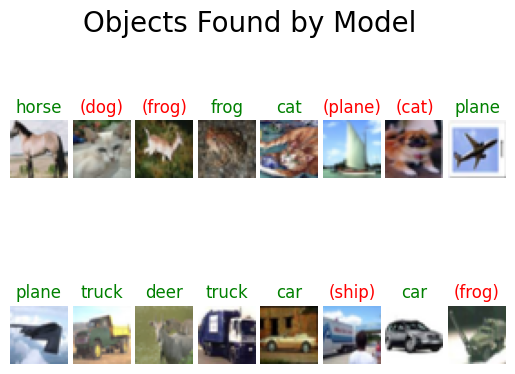

In [5]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.subplots_adjust(hspace=0.01, wspace=0.08)  # Adjust the value as needed
plt.show()

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [7]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.3 %
Accuracy for class: car   is 72.2 %
Accuracy for class: bird  is 44.4 %
Accuracy for class: cat   is 39.9 %
Accuracy for class: deer  is 52.9 %
Accuracy for class: dog   is 48.0 %
Accuracy for class: frog  is 70.1 %
Accuracy for class: horse is 64.0 %
Accuracy for class: ship  is 68.3 %
Accuracy for class: truck is 66.1 %


## Step 6 - Inspect model


In [25]:
weights = net.fc1.bias
print(weights)


Parameter containing:
tensor([ 1.0693e-03,  9.9330e-03,  1.1772e-02,  4.1826e-02, -1.6703e-03,
         2.2243e-02, -2.2843e-02,  3.0305e-02,  1.5157e-02, -3.0951e-03,
        -6.4404e-02,  1.1834e-02, -1.0137e-02, -3.1037e-03,  5.7597e-02,
        -8.2950e-03,  3.6071e-02, -1.5311e-02, -3.7600e-03,  1.0481e-02,
        -5.9608e-03, -8.6664e-04,  8.2750e-03,  1.2962e-02,  3.6283e-03,
        -1.9007e-03,  3.3955e-04, -2.3750e-03, -1.3322e-02, -6.7555e-02,
        -1.3890e-03, -2.2227e-02,  4.1993e-02, -5.7290e-04,  5.8806e-02,
         1.8475e-02,  7.6559e-02, -3.7171e-03,  1.1156e-01, -3.6909e-02,
         1.4458e-02,  5.0647e-04,  9.3352e-03,  1.0011e-02, -1.4442e-04,
         1.8871e-02,  4.2838e-03,  1.4597e-02, -6.0087e-04,  1.2865e-02,
         2.0386e-02,  3.3519e-02, -7.6242e-04, -1.8929e-02,  1.9818e-02,
         1.9796e-02, -1.0436e-02, -2.8480e-02,  8.3651e-04, -3.0594e-03,
         3.8332e-02, -7.8027e-03, -5.7984e-03, -5.1590e-03, -6.8027e-03,
         3.6393e-03,  3.7983e